### 0. Imports and Setups

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque, defaultdict
import collections
import pickle
from tqdm import tqdm

# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
import time

# for plotting graphs
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!cp '/content/gdrive/MyDrive/Colab Notebooks/Deep RL Assignment/Env.py' .
!cp '/content/gdrive/MyDrive/Colab Notebooks/Deep RL Assignment/TM.npy' .

In [5]:

# Import the environment
from Env import CabDriver

#### 1. Defining Time Matrix

In [6]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [7]:
Time_matrix.shape

(5, 5, 24, 7)

In [8]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


**Observation**
- The time matrix is 4 dimensional - start_location, end_location, hour of day, day of the week
-  The max time taken between 2 consequtive points is 11 hours, time can increase by a day

###2.  Defining the MDP Environment

In [9]:
env = CabDriver()
action_space, state_space, state = env.reset()

In [ ]:
action_space

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3)]

In [ ]:
state_space

[[0, 0, 0],
 [0, 0, 1],
 [0, 0, 2],
 [0, 0, 3],
 [0, 0, 4],
 [0, 0, 5],
 [0, 0, 6],
 [0, 1, 0],
 [0, 1, 1],
 [0, 1, 2],
 [0, 1, 3],
 [0, 1, 4],
 [0, 1, 5],
 [0, 1, 6],
 [0, 2, 0],
 [0, 2, 1],
 [0, 2, 2],
 [0, 2, 3],
 [0, 2, 4],
 [0, 2, 5],
 [0, 2, 6],
 [0, 3, 0],
 [0, 3, 1],
 [0, 3, 2],
 [0, 3, 3],
 [0, 3, 4],
 [0, 3, 5],
 [0, 3, 6],
 [0, 4, 0],
 [0, 4, 1],
 [0, 4, 2],
 [0, 4, 3],
 [0, 4, 4],
 [0, 4, 5],
 [0, 4, 6],
 [0, 5, 0],
 [0, 5, 1],
 [0, 5, 2],
 [0, 5, 3],
 [0, 5, 4],
 [0, 5, 5],
 [0, 5, 6],
 [0, 6, 0],
 [0, 6, 1],
 [0, 6, 2],
 [0, 6, 3],
 [0, 6, 4],
 [0, 6, 5],
 [0, 6, 6],
 [0, 7, 0],
 [0, 7, 1],
 [0, 7, 2],
 [0, 7, 3],
 [0, 7, 4],
 [0, 7, 5],
 [0, 7, 6],
 [0, 8, 0],
 [0, 8, 1],
 [0, 8, 2],
 [0, 8, 3],
 [0, 8, 4],
 [0, 8, 5],
 [0, 8, 6],
 [0, 9, 0],
 [0, 9, 1],
 [0, 9, 2],
 [0, 9, 3],
 [0, 9, 4],
 [0, 9, 5],
 [0, 9, 6],
 [0, 10, 0],
 [0, 10, 1],
 [0, 10, 2],
 [0, 10, 3],
 [0, 10, 4],
 [0, 10, 5],
 [0, 10, 6],
 [0, 11, 0],
 [0, 11, 1],
 [0, 11, 2],
 [0, 11, 3],
 [0, 11, 4],
 [0,

**Observation**
- The state spaces are correctly initialized into a Vector [State, Day, Hour]

In [ ]:
print ("The randomly initialized state is {}".format(state))

The randomly initialized state is [2, 6, 6]


In [ ]:
#env.self_state_init_for_test([0,17,5])
env.requests(state)

([11, 13, 15, 3, 6, 4, 2, 9, 0],
 [(2, 3), (3, 0), (3, 2), (0, 3), (1, 2), (0, 4), (0, 2), (2, 0), (0, 0)])

**Observation** 
- Returns the correct randomised action, and corresponding index, based on the traffic (Poisson Random Variable) for the location

In [ ]:
Time_matrix[4,3,17,5]

6.0

In [ ]:
env.next_state_func(state,[4,3],Time_matrix)

([3, 17, 6], 0, 4.0, 7.0)

In [ ]:
state = [0,1,2]
env.state_encod_arch1(state)

[1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0]

**Observation** 
- The universal state space and action space look properly initialized
- The current state is randomly initialized
- The request function returns random states based on Traffic
- The next state is being generated, and encoded correctly

#### 2. Utilties

In [ ]:

#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


##### Epsilon- Greedy strategy

Way of selecting random actions with uniform distribution.
We can either select random action with epsilon probability or
We can select an action with 1-epsilon probably which will give maximum reward in a given state

Check epsilon decay over episodes

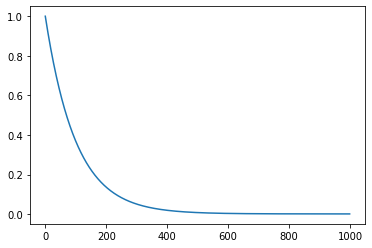

In [ ]:
max_epsilon = 1.0
min_epsilon = 0.001
#decay_rate = -0.1
decay_rate = -0.01
time_tic = np.arange(0,1000)
epsilon = []

#Number of episodes for training
for i in time_tic:
     epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(decay_rate*i))

plt.plot(time_tic, epsilon)
plt.show()


##### Initialize Tracking States

In [10]:
def initialize_tracking_states():
    state_action_pair = [((0, 0, 0), (0, 1)),
                         ((0, 1, 1), (3, 4)),
                         ((1, 2, 2), (0, 2)),
                         ((1, 2, 2), (2, 3)),
                         ((2, 3, 3), (2, 1)),
                         ((2, 3, 3), (3, 4)),
                         ((3, 4, 4), (3, 0)), 
                         ((4, 4, 4), (1, 0)),
                         ((4, 5, 5), (0, 1)),
                         ((4, 5, 5), (1, 2))]

    for state, action in state_action_pair:
        if state not in tracked_states:
            tracked_states[state] = defaultdict()
        tracked_states[state][action] = list()




##### Persist q-values corresponding for tracked states

In [11]:
def update_tracking_states(driver):
    for state in tracked_states.keys():
        encoded_state = np.array(env.state_encod_arch1(state)).reshape(1, 36)
        q_predict = driver.model.predict(encoded_state)
        

        for action in tracked_states[state].keys():            
            action_index = list(
                filter(
                    lambda x: action == env.action_space[x],
                    range(0, len(env.action_space))))[0]
            q_value = q_predict[0][action_index]            
            tracked_states[state][action].append(q_value)

## 3. Defining the Agent Class

In this framework, we need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.


## Hyper parameters

*  state_size : vector length of encoded states (number of neurons in input layer) 
*   action_size : vector length of predicted q_values for all actions 
*  learning_rate
*  discount_factor
*  batch_size : batch size used in neural network for training
*  memory_length : replay memory buffer size



In [12]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        #self.epsilon_decay = -0.0005 #for 15k
        #self.epsilon_decay = -0.00015 #for 20k
        self.epsilon_decay = -0.01 # for 1k
        #self.epsilon_decay = -0.1 # for 100        
        self.epsilon_min = 0.001 
     
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        """
        Function that takes in the agent and constructs the network
        to train it
        @return model
        @params agent
        """
        input_shape = self.state_size
        model = Sequential()
        # Input layer : 'state_size'       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        # Hidden Layers
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # Output Layer : 'action_size'
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        model.summary()
        return model

  
    def get_action(self, state, possible_actions_index, actions):
        """
        get action in a state according to an epsilon-greedy approach
        possible_actions_index, actions are the 'ride requests' that teh driver got.
        """        
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)            
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]
     
            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample(self, state, action_index, reward, next_state, done):
        """appends the new agent run output to replay buffer"""
        self.memory.append((state, action_index, reward, next_state, done))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """ 
        Function to train the model on eacg step run.
        Picks the random memory events according to batch size and 
        runs it through the network to train it.
        """
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
           
            # initialize input state vector S
            state_input = np.zeros((self.batch_size, self.state_size))
            # initialize input state vector S'
            next_state_input = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate state_input, next_state_input and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                state_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                next_state_input[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # once the input matrices S and S' have been created, perform a feed-forward.
            # this will generate q-values for all possible actions of a batch input

            # generate Q(s, a)
            state_q_values = self.model.predict(state_input)
            # generate Q(s', a)
            next_state_q_values = self.model.predict(next_state_input)


            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    state_q_values[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    state_q_values[i][actions[i]] = rewards[i] + self.discount_factor * np.max(next_state_q_values[i])
            # model fit
            self.model.fit(state_input, state_q_values, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        
    def save_test_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_test.append(q_value[0][2])

    def save(self, name):
        save_obj(self.model, name)
    

## Initialization

In [ ]:
#Initiaze sample tracking states
tracked_states = defaultdict()
initialize_tracking_states()
tracked_states

defaultdict(None,
            {(0, 0, 0): defaultdict(None, {(0, 1): []}),
             (0, 1, 1): defaultdict(None, {(3, 4): []}),
             (1, 2, 2): defaultdict(None, {(0, 2): [], (2, 3): []}),
             (2, 3, 3): defaultdict(None, {(2, 1): [], (3, 4): []}),
             (3, 4, 4): defaultdict(None, {(3, 0): []}),
             (4, 4, 4): defaultdict(None, {(1, 0): []}),
             (4, 5, 5): defaultdict(None, {(0, 1): [], (1, 2): []})})

### 4. Training - DQN block

In [ ]:
#Initialize the DQN Block 

episode_time = 24*30 #30 days before which car has to be recharged
total_episodes = 1000
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# to store rewards in each episode
rewards_per_episode, episodes = [], []





In [ ]:

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1184      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 21)                693       
                                                                 
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________


## 5. Training Iteration

In [ ]:
start_time = time.time()
score_tracked = []


for episode in tqdm(range(total_episodes)):

    terminal_state = False
    score = 0
    track_reward = False

    #reset at the start of each episode
    env = CabDriver()
    action_space, state_space, current_state = env.reset()
    

    total_time = 0
    while not terminal_state:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(current_state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        current_action_idx = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(current_state, env.action_space[current_action_idx], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
          # if ride does not complete in stipulated time skip
          # it and move to next episode.
          terminal_state = True
        else:
          # 5. Append the experience to the memory
          agent.append_sample(current_state, current_action_idx, reward, next_state, terminal_state)
          # 6. Train the model by calling function agent.train_model
          agent.train_model()
          # 7. Keep a track of rewards, Q-values, loss
          score += reward
          current_state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
      

    # epsilon decay
    agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(agent.epsilon_decay * episode)

    # every 100 episodes:
    if ((episode + 1) % 100 == 0):
        print("\nEpisode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}\n".format(episode + 1,
                                                score,len(agent.memory),agent.epsilon, total_time))
        
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 50 == 0):       
        update_tracking_states(agent)

    # Total rewards per episode
    score_tracked.append(score)

           
elapsed_time = time.time() - start_time
print("\nElapsed Time :", elapsed_time, "\n")

 10%|▉         | 99/1000 [26:06<3:55:40, 15.69s/it]


Episode 100, reward -168.0, memory_length 2000, epsilon 0.37220511433102366 total_time 725.0



 20%|█▉        | 199/1000 [50:44<3:04:52, 13.85s/it]


Episode 200, reward -219.0, memory_length 2000, epsilon 0.13755873002007832 total_time 728.0



 30%|██▉       | 299/1000 [1:15:38<2:49:52, 14.54s/it]


Episode 300, reward -247.0, memory_length 2000, epsilon 0.051237149286868275 total_time 729.0



 40%|███▉      | 399/1000 [1:41:07<2:29:24, 14.92s/it]


Episode 400, reward -309.0, memory_length 2000, epsilon 0.019481214405699422 total_time 726.0



 50%|████▉     | 499/1000 [2:06:24<2:08:49, 15.43s/it]


Episode 500, reward -265.0, memory_length 2000, epsilon 0.0077988588277383124 total_time 726.0



 60%|█████▉    | 599/1000 [2:31:53<1:41:03, 15.12s/it]


Episode 600, reward -110.0, memory_length 2000, epsilon 0.003501160386151898 total_time 721.0



 70%|██████▉   | 699/1000 [2:56:00<1:18:01, 15.55s/it]


Episode 700, reward 257.0, memory_length 2000, epsilon 0.001920125485137709 total_time 722.0



 80%|███████▉  | 799/1000 [3:21:28<49:23, 14.74s/it]


Episode 800, reward 81.0, memory_length 2000, epsilon 0.0013384952492800626 total_time 722.0



 90%|████████▉ | 899/1000 [3:46:17<22:37, 13.44s/it]


Episode 900, reward -11.0, memory_length 2000, epsilon 0.0011245254431443375 total_time 728.0



100%|█████████▉| 999/1000 [4:11:07<00:14, 14.87s/it]


Episode 1000, reward 149.0, memory_length 2000, epsilon 0.0010458103504355652 total_time 722.0



100%|██████████| 1000/1000 [4:11:24<00:00, 15.08s/it]


Elapsed Time : 15084.542959451675 



**Observation** 
- The 'total_time' above includes the 'last ride' time also in each episode. Although it exceeds 24*30 = 720, our code drops the last ride from the replay buffer. So the total ride time per episode is limited to < 720


In [ ]:
agent.save(name="model_weights")

INFO:tensorflow:Assets written to: ram://f2197400-308d-4608-844e-cc1e038aeae0/assets


### 5. Tracking Convergence

In [ ]:
 tracked_states_plotting=[]
 for st in tracked_states.keys():
        for ac in tracked_states[st].keys():
            number_of_tracked_q_values = len(list(filter(lambda x: x!= 0, tracked_states[st][ac])))
            print('state - {0} - action - {1} - {2}'.format(st, ac, number_of_tracked_q_values))
            # selecting only the states with non-zero values for plotting
            if (number_of_tracked_q_values):              
              tracked_states_plotting.append((st,ac))



state - (0, 0, 0) - action - (0, 1) - 20
state - (0, 1, 1) - action - (3, 4) - 19
state - (1, 2, 2) - action - (0, 2) - 0
state - (1, 2, 2) - action - (2, 3) - 20
state - (2, 3, 3) - action - (2, 1) - 20
state - (2, 3, 3) - action - (3, 4) - 19
state - (3, 4, 4) - action - (3, 0) - 0
state - (4, 4, 4) - action - (1, 0) - 20
state - (4, 5, 5) - action - (0, 1) - 20
state - (4, 5, 5) - action - (1, 2) - 20


**Observation** 
- There are values in the saved states which can be plotted


**draw convergence plot for a state - action pair**

In [23]:
def plot_q_val_convergence(state, action):

    tracked_q_values = tracked_states[state][action]
    number_of_tracked_episodes = len(tracked_q_values)
    plt.plot(range(0, number_of_tracked_episodes), tracked_q_values)
        
    plt.ylabel("Q_value")
    
    plt.title("State : {0} - Action : {1}".format(state, action))
    plt.legend(["Q-value"], loc="lower right")

In [24]:
def plot_q_val_log_convergence(state, action):

    tracked_q_values = tracked_states[state][action]
    number_of_tracked_episodes = len(tracked_q_values)
    plt.semilogy(range(0, number_of_tracked_episodes), tracked_q_values)
        
    plt.ylabel("Q_value")
    
    plt.title("State : {0} - Action : {1}".format(state, action))
    plt.legend(["Q-value"], loc="lower right")



**Display convergence of tracked states**

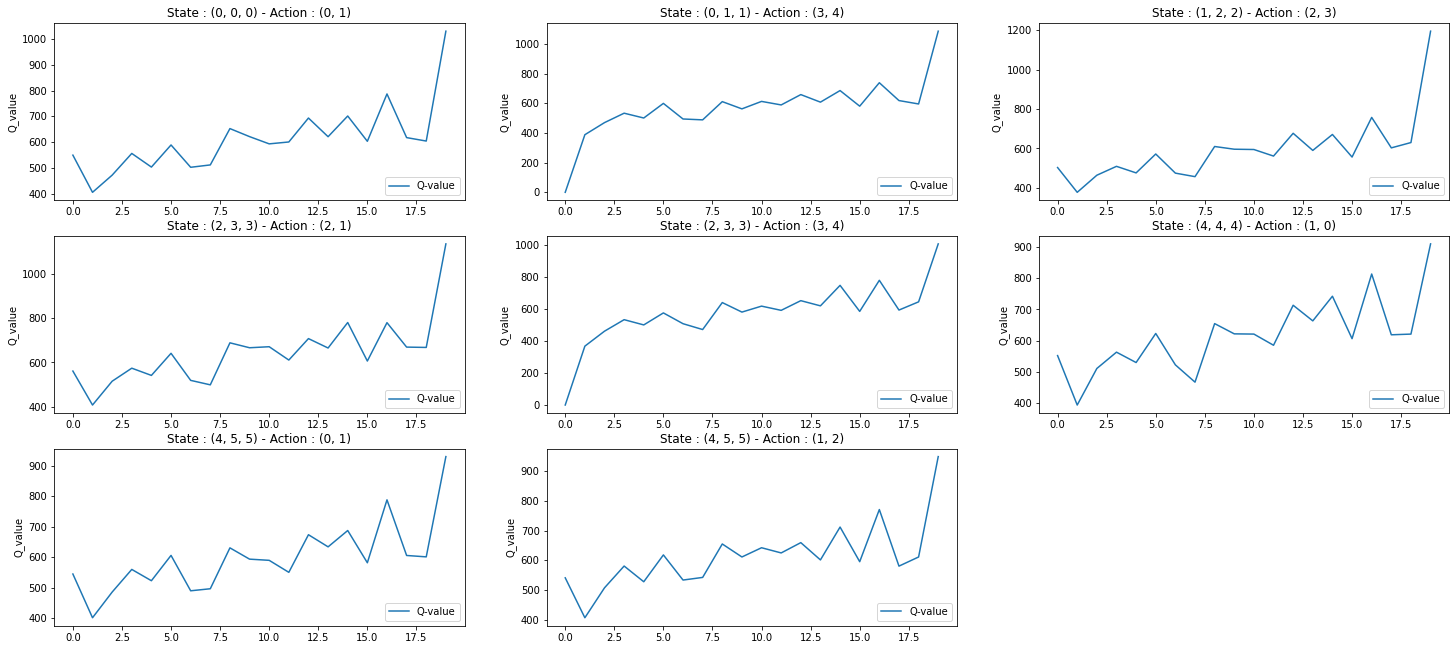

In [ ]:
plt.figure(0, figsize=(25, 15))
i = 0
for state, action in tracked_states_plotting:
    plt.subplot(4,3, i + 1)
    plot_q_val_convergence(state, action)
    i +=1

**Observation** 
- The Q Value is steadily increasing as the number of runs are increasing, which shows that the model is learning

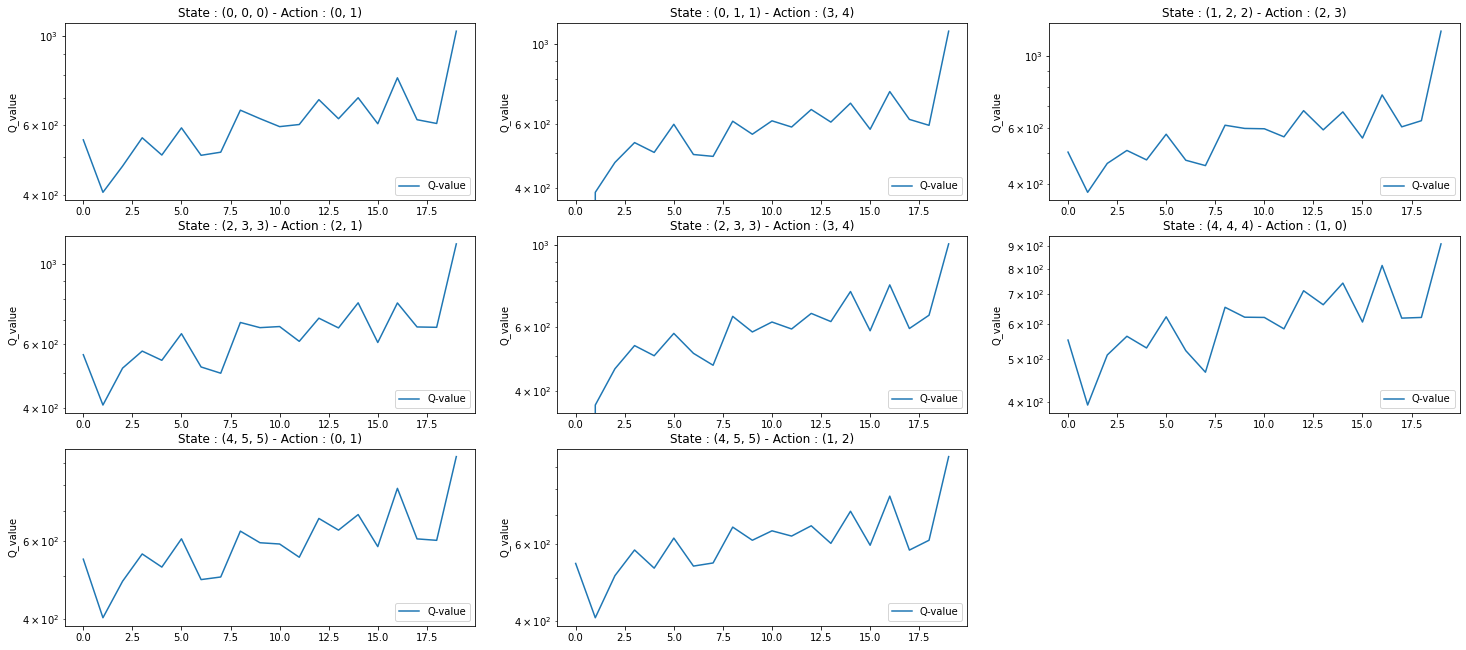

In [ ]:
plt.figure(0, figsize=(25, 15))
i = 0
for state, action in tracked_states_plotting:
    plt.subplot(4,3, i + 1)
    plot_q_val_log_convergence(state, action)
    i +=1

**Observation** 
- The Log Scale is not that useful in smoothening the curve as the number of runs are restricted to 1000. 
- We can repeat the experiment with close to 15K runs and check for improvement of Q Values

**Plotting Average Monthly Rewards**

In [ ]:
!cp model_weights.pkl '/content/gdrive/MyDrive/Colab Notebooks/Deep RL Assignment/model_weights.pkl'

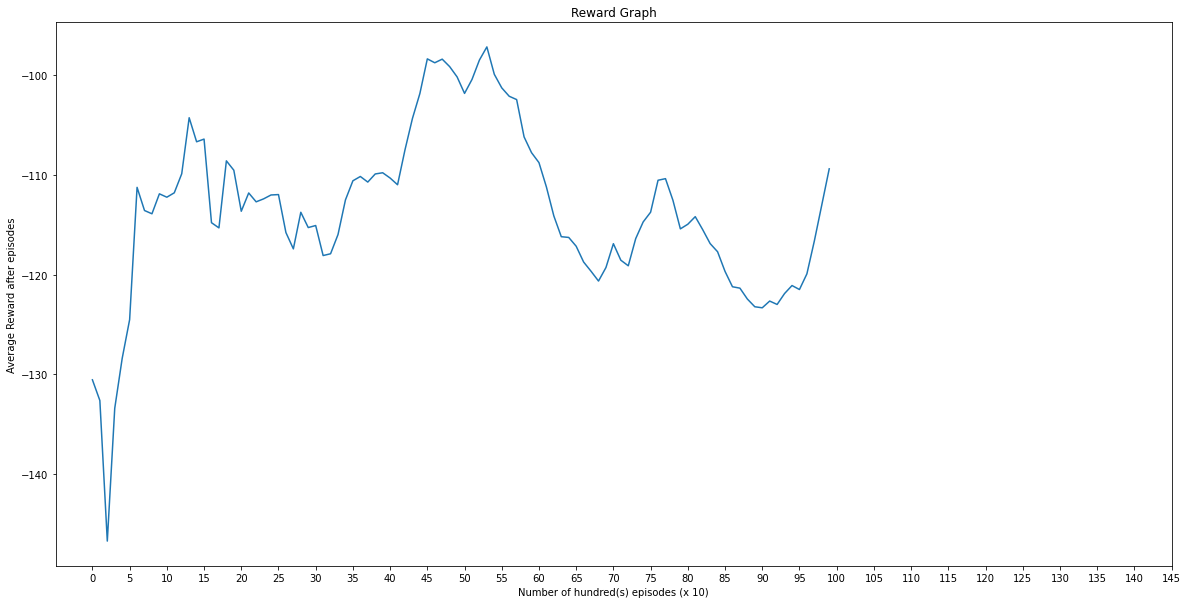

In [ ]:
avg_monthly_rewards = [
    np.mean(rewards_per_episode[0:x + 9])
    for x in range(0, total_episodes, 10)
]

plt.figure(figsize=(20, 10))

plt.plot(range(0, len(avg_monthly_rewards)), avg_monthly_rewards)

plt.xlabel("Number of hundred(s) episodes (x 10)")
plt.ylabel("Average Reward after episodes")
plt.title("Reward Graph")
plt.xticks(range(0, 150, 5))

plt.show()

**Conclusion**
- We have been able to create a Deep Q Model, which learns the Env and able to predict Actions, which can maximise the reward, which is the goal of this experiment
- As seen below, we start with a low Reward, and slowly the graph rises up to better rewards
- Having said that, we need to run many more iterations, to get to better results, which we havent done due to infrastructure and time constraints.

In [14]:
from keras import backend as K
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()
jobs = 8 # Play around with this number
config = tf.ConfigProto(intra_op_parallelism_threads=jobs,
                         inter_op_parallelism_threads=jobs,
                         allow_soft_placement=True,
                         device_count={'CPU': jobs})
session = tf.Session(config=config)
K.set_session(session)

Instructions for updating:
non-resource variables are not supported in the long term


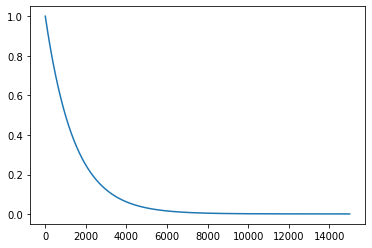

In [16]:
max_epsilon = 1.0
min_epsilon = 0.001
#decay_rate = -0.1
decay_rate = -0.0007
time_tic = np.arange(0,15000)
epsilon = []

#Number of episodes for training
for i in time_tic:
     epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(decay_rate*i))

plt.plot(time_tic, epsilon)
plt.show()

## Initialization

In [15]:
#Initiaze sample tracking states
tracked_states = defaultdict()
initialize_tracking_states()
tracked_states

defaultdict(None,
            {(0, 0, 0): defaultdict(None, {(0, 1): []}),
             (0, 1, 1): defaultdict(None, {(3, 4): []}),
             (1, 2, 2): defaultdict(None, {(0, 2): [], (2, 3): []}),
             (2, 3, 3): defaultdict(None, {(2, 1): [], (3, 4): []}),
             (3, 4, 4): defaultdict(None, {(3, 0): []}),
             (4, 4, 4): defaultdict(None, {(1, 0): []}),
             (4, 5, 5): defaultdict(None, {(0, 1): [], (1, 2): []})})

In [17]:
#Initialize the DQN Block 

episode_time = 24*30 #30 days before which car has to be recharged
total_episodes = 15000
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# to store rewards in each episode
rewards_per_episode, episodes = [], []


In [19]:

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)


agent.epsilon_min = 1.0
agent.epsilon_max = 0.001
agent.epsilon_decay = -0.0007


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                1184      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 21)                693       
                                                                 
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________


In [20]:
start_time = time.time()
score_tracked = []


for episode in tqdm(range(total_episodes)):

    terminal_state = False
    score = 0
    track_reward = False

    #reset at the start of each episode
    env = CabDriver()
    action_space, state_space, current_state = env.reset()
    

    total_time = 0
    while not terminal_state:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(current_state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        current_action_idx = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(current_state, env.action_space[current_action_idx], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
          # if ride does not complete in stipulated time skip
          # it and move to next episode.
          terminal_state = True
        else:
          # 5. Append the experience to the memory
          agent.append_sample(current_state, current_action_idx, reward, next_state, terminal_state)
          # 6. Train the model by calling function agent.train_model
          agent.train_model()
          # 7. Keep a track of rewards, Q-values, loss
          score += reward
          current_state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
      

    # epsilon decay
    agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(agent.epsilon_decay * episode)

    # every 100 episodes:
    if ((episode + 1) % 100 == 0):
        print("\nEpisode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}\n".format(episode + 1,
                                                score,len(agent.memory),agent.epsilon, total_time))
        
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 50 == 0):       
        update_tracking_states(agent)

    # Total rewards per episode
    score_tracked.append(score)

           
elapsed_time = time.time() - start_time
print("\nElapsed Time :", elapsed_time, "\n")

  0%|          | 0/15000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
  1%|          | 100/15000 [01:07<2:34:59,  1.60it/s]


Episode 100, reward 27.0, memory_length 2000, epsilon 0.06788632265439021 total_time 737.0



  1%|▏         | 200/15000 [02:14<3:01:38,  1.36it/s]


Episode 200, reward -315.0, memory_length 2000, epsilon 0.13090296779314636 total_time 722.0



  2%|▏         | 300/15000 [03:26<3:11:17,  1.28it/s]


Episode 300, reward -192.0, memory_length 2000, epsilon 0.18965929827172878 total_time 725.0



  3%|▎         | 400/15000 [04:37<2:59:59,  1.35it/s]


Episode 400, reward -270.0, memory_length 2000, epsilon 0.24444333769031068 total_time 726.0



  3%|▎         | 500/15000 [05:47<2:48:02,  1.44it/s]


Episode 500, reward 137.0, memory_length 2000, epsilon 0.29552363747368016 total_time 728.0



  4%|▍         | 600/15000 [07:02<3:10:08,  1.26it/s]


Episode 600, reward 86.0, memory_length 2000, epsilon 0.34315059331063713 total_time 732.0



  5%|▍         | 700/15000 [08:21<3:09:38,  1.26it/s]


Episode 700, reward 48.0, memory_length 2000, epsilon 0.38755767259394924 total_time 722.0



  5%|▌         | 800/15000 [09:39<3:18:35,  1.19it/s]


Episode 800, reward 573.0, memory_length 2000, epsilon 0.4289625588777829 total_time 729.0



  6%|▌         | 900/15000 [10:55<2:46:58,  1.41it/s]


Episode 900, reward -126.0, memory_length 2000, epsilon 0.4675682189627379 total_time 726.0



  7%|▋         | 1000/15000 [12:10<3:11:43,  1.22it/s]


Episode 1000, reward -53.0, memory_length 2000, epsilon 0.5035638978393399 total_time 726.0



  7%|▋         | 1100/15000 [13:24<2:50:02,  1.36it/s]


Episode 1100, reward -211.0, memory_length 2000, epsilon 0.5371260463672025 total_time 729.0



  8%|▊         | 1200/15000 [14:36<3:00:42,  1.27it/s]


Episode 1200, reward -143.0, memory_length 2000, epsilon 0.5684191862373471 total_time 723.0



  9%|▊         | 1300/15000 [15:54<2:56:38,  1.29it/s]


Episode 1300, reward 149.0, memory_length 2000, epsilon 0.5975967164577225 total_time 731.0



  9%|▉         | 1400/15000 [17:12<2:48:02,  1.35it/s]


Episode 1400, reward 158.0, memory_length 2000, epsilon 0.6248016653153194 total_time 722.0



 10%|█         | 1500/15000 [18:32<2:57:04,  1.27it/s]


Episode 1500, reward 78.0, memory_length 2000, epsilon 0.6501673915010002 total_time 721.0



 11%|█         | 1600/15000 [19:51<3:03:02,  1.22it/s]


Episode 1600, reward -189.0, memory_length 2000, epsilon 0.6738182378339556 total_time 721.0



 11%|█▏        | 1700/15000 [21:09<2:45:07,  1.34it/s]


Episode 1700, reward 78.0, memory_length 2000, epsilon 0.6958701407903484 total_time 728.0



 12%|█▏        | 1800/15000 [22:25<3:00:51,  1.22it/s]


Episode 1800, reward 11.0, memory_length 2000, epsilon 0.7164311988240547 total_time 722.0



 13%|█▎        | 1900/15000 [23:40<2:48:39,  1.29it/s]


Episode 1900, reward 14.0, memory_length 2000, epsilon 0.7356022022654101 total_time 727.0



 13%|█▎        | 2000/15000 [24:57<2:44:40,  1.32it/s]


Episode 2000, reward -111.0, memory_length 2000, epsilon 0.7534771273955253 total_time 730.0



 14%|█▍        | 2100/15000 [26:15<2:49:13,  1.27it/s]


Episode 2100, reward -90.0, memory_length 2000, epsilon 0.7701435971181265 total_time 727.0



 15%|█▍        | 2200/15000 [27:32<3:03:36,  1.16it/s]


Episode 2200, reward -318.0, memory_length 2000, epsilon 0.7856833104871292 total_time 721.0



 15%|█▌        | 2300/15000 [28:48<2:47:48,  1.26it/s]


Episode 2300, reward 41.0, memory_length 2000, epsilon 0.8001724431954974 total_time 723.0



 16%|█▌        | 2400/15000 [30:06<2:43:13,  1.29it/s]


Episode 2400, reward -368.0, memory_length 2000, epsilon 0.813682020988577 total_time 726.0



 17%|█▋        | 2500/15000 [31:24<2:49:10,  1.23it/s]


Episode 2500, reward -183.0, memory_length 2000, epsilon 0.826278267832383 total_time 726.0



 17%|█▋        | 2600/15000 [32:43<2:43:32,  1.26it/s]


Episode 2600, reward -229.0, memory_length 2000, epsilon 0.8380229305435576 total_time 733.0



 18%|█▊        | 2700/15000 [34:03<2:52:29,  1.19it/s]


Episode 2700, reward -127.0, memory_length 2000, epsilon 0.8489735814723365 total_time 726.0



 19%|█▊        | 2800/15000 [35:23<2:42:10,  1.25it/s]


Episode 2800, reward 253.0, memory_length 2000, epsilon 0.8591839007222773 total_time 721.0



 19%|█▉        | 2900/15000 [36:44<2:44:02,  1.23it/s]


Episode 2900, reward -100.0, memory_length 2000, epsilon 0.868703939290189 total_time 728.0



 20%|██        | 3000/15000 [38:05<2:32:43,  1.31it/s]


Episode 3000, reward -227.0, memory_length 2000, epsilon 0.877580364416176 total_time 724.0



 21%|██        | 3100/15000 [39:27<2:45:42,  1.20it/s]


Episode 3100, reward -326.0, memory_length 2000, epsilon 0.8858566883465042 total_time 728.0



 21%|██▏       | 3200/15000 [40:47<2:40:09,  1.23it/s]


Episode 3200, reward -80.0, memory_length 2000, epsilon 0.893573481630682 total_time 721.0



 22%|██▏       | 3300/15000 [42:10<2:27:05,  1.33it/s]


Episode 3300, reward 64.0, memory_length 2000, epsilon 0.9007685719983409 total_time 722.0



 23%|██▎       | 3400/15000 [43:29<2:34:30,  1.25it/s]


Episode 3400, reward 107.0, memory_length 2000, epsilon 0.907477229790811 total_time 721.0



 23%|██▎       | 3500/15000 [44:49<2:33:54,  1.25it/s]


Episode 3500, reward -161.0, memory_length 2000, epsilon 0.913732340856374 total_time 721.0



 24%|██▍       | 3600/15000 [46:08<2:22:46,  1.33it/s]


Episode 3600, reward 155.0, memory_length 2000, epsilon 0.9195645677567302 total_time 731.0



 25%|██▍       | 3700/15000 [47:29<2:36:32,  1.20it/s]


Episode 3700, reward -128.0, memory_length 2000, epsilon 0.9250025000749117 total_time 721.0



 25%|██▌       | 3800/15000 [48:50<2:28:19,  1.26it/s]


Episode 3800, reward -93.0, memory_length 2000, epsilon 0.9300727945614509 total_time 721.0



 26%|██▌       | 3900/15000 [50:11<2:23:34,  1.29it/s]


Episode 3900, reward -152.0, memory_length 2000, epsilon 0.9348003058058031 total_time 729.0



 27%|██▋       | 4000/15000 [51:30<2:25:01,  1.26it/s]


Episode 4000, reward -3.0, memory_length 2000, epsilon 0.9392082080735731 total_time 726.0



 27%|██▋       | 4100/15000 [52:51<2:21:22,  1.29it/s]


Episode 4100, reward -216.0, memory_length 2000, epsilon 0.9433181089067912 total_time 721.0



 28%|██▊       | 4200/15000 [54:10<2:24:34,  1.25it/s]


Episode 4200, reward 146.0, memory_length 2000, epsilon 0.9471501550441102 total_time 724.0



 29%|██▊       | 4300/15000 [55:29<2:29:23,  1.19it/s]


Episode 4300, reward -134.0, memory_length 2000, epsilon 0.9507231311801407 total_time 728.0



 29%|██▉       | 4400/15000 [56:51<2:25:01,  1.22it/s]


Episode 4400, reward 110.0, memory_length 2000, epsilon 0.9540545520480471 total_time 722.0



 30%|███       | 4500/15000 [58:11<2:18:29,  1.26it/s]


Episode 4500, reward -26.0, memory_length 2000, epsilon 0.9571607482767888 total_time 726.0



 31%|███       | 4600/15000 [59:30<2:24:43,  1.20it/s]


Episode 4600, reward -353.0, memory_length 2000, epsilon 0.9600569464438826 total_time 722.0



 31%|███▏      | 4700/15000 [1:00:51<2:14:40,  1.27it/s]


Episode 4700, reward -81.0, memory_length 2000, epsilon 0.9627573437161038 total_time 732.0



 32%|███▏      | 4800/15000 [1:02:14<2:21:16,  1.20it/s]


Episode 4800, reward -129.0, memory_length 2000, epsilon 0.9652751774440138 total_time 729.0



 33%|███▎      | 4900/15000 [1:03:37<2:14:47,  1.25it/s]


Episode 4900, reward -144.0, memory_length 2000, epsilon 0.9676227900514678 total_time 724.0



 33%|███▎      | 5000/15000 [1:05:00<2:20:42,  1.18it/s]


Episode 5000, reward 104.0, memory_length 2000, epsilon 0.9698116895381912 total_time 723.0



 34%|███▍      | 5100/15000 [1:06:25<2:31:14,  1.09it/s]


Episode 5100, reward -360.0, memory_length 2000, epsilon 0.9718526058920074 total_time 726.0



 35%|███▍      | 5200/15000 [1:07:48<2:25:04,  1.13it/s]


Episode 5200, reward -53.0, memory_length 2000, epsilon 0.9737555436872506 total_time 729.0



 35%|███▌      | 5300/15000 [1:09:09<2:09:20,  1.25it/s]


Episode 5300, reward -368.0, memory_length 2000, epsilon 0.9755298311272007 total_time 724.0



 36%|███▌      | 5400/15000 [1:10:30<2:09:35,  1.23it/s]


Episode 5400, reward 51.0, memory_length 2000, epsilon 0.9771841657709471 total_time 727.0



 37%|███▋      | 5500/15000 [1:11:52<2:08:41,  1.23it/s]


Episode 5500, reward -130.0, memory_length 2000, epsilon 0.9787266571688324 total_time 727.0



 37%|███▋      | 5600/15000 [1:13:13<2:17:35,  1.14it/s]


Episode 5600, reward -332.0, memory_length 2000, epsilon 0.9801648666154789 total_time 731.0



 38%|███▊      | 5700/15000 [1:14:35<2:08:35,  1.21it/s]


Episode 5700, reward -254.0, memory_length 2000, epsilon 0.9815058442152623 total_time 725.0



 39%|███▊      | 5800/15000 [1:15:57<2:09:49,  1.18it/s]


Episode 5800, reward -261.0, memory_length 2000, epsilon 0.9827561634419328 total_time 721.0



 39%|███▉      | 5900/15000 [1:17:18<2:03:31,  1.23it/s]


Episode 5900, reward -270.0, memory_length 2000, epsilon 0.9839219533617899 total_time 729.0



 40%|████      | 6000/15000 [1:18:40<2:11:07,  1.14it/s]


Episode 6000, reward -282.0, memory_length 2000, epsilon 0.9850089286783733 total_time 728.0



 41%|████      | 6100/15000 [1:20:04<2:10:36,  1.14it/s]


Episode 6100, reward -350.0, memory_length 2000, epsilon 0.9860224177459459 total_time 722.0



 41%|████▏     | 6200/15000 [1:21:27<1:59:36,  1.23it/s]


Episode 6200, reward -244.0, memory_length 2000, epsilon 0.986967388689093 total_time 724.0



 42%|████▏     | 6300/15000 [1:22:49<1:54:05,  1.27it/s]


Episode 6300, reward -16.0, memory_length 2000, epsilon 0.9878484737564739 total_time 726.0



 43%|████▎     | 6400/15000 [1:24:11<1:50:06,  1.30it/s]


Episode 6400, reward -175.0, memory_length 2000, epsilon 0.9886699920281113 total_time 723.0



 43%|████▎     | 6500/15000 [1:25:32<1:55:26,  1.23it/s]


Episode 6500, reward -210.0, memory_length 2000, epsilon 0.9894359705875259 total_time 731.0



 44%|████▍     | 6600/15000 [1:26:54<1:50:50,  1.26it/s]


Episode 6600, reward -334.0, memory_length 2000, epsilon 0.9901501642625045 total_time 724.0



 45%|████▍     | 6700/15000 [1:28:14<1:51:34,  1.24it/s]


Episode 6700, reward -260.0, memory_length 2000, epsilon 0.9908160740312704 total_time 722.0



 45%|████▌     | 6800/15000 [1:29:36<1:56:01,  1.18it/s]


Episode 6800, reward -224.0, memory_length 2000, epsilon 0.9914369641842827 total_time 735.0



 46%|████▌     | 6900/15000 [1:30:58<1:52:26,  1.20it/s]


Episode 6900, reward 211.0, memory_length 2000, epsilon 0.992015878325792 total_time 723.0



 47%|████▋     | 7000/15000 [1:32:20<1:50:53,  1.20it/s]


Episode 7000, reward -432.0, memory_length 2000, epsilon 0.9925556542935913 total_time 721.0



 47%|████▋     | 7100/15000 [1:33:40<1:45:48,  1.24it/s]


Episode 7100, reward 247.0, memory_length 2000, epsilon 0.9930589380701011 total_time 723.0



 48%|████▊     | 7200/15000 [1:35:05<1:47:43,  1.21it/s]


Episode 7200, reward -9.0, memory_length 2000, epsilon 0.9935281967529779 total_time 725.0



 49%|████▊     | 7300/15000 [1:36:28<1:43:32,  1.24it/s]


Episode 7300, reward -64.0, memory_length 2000, epsilon 0.9939657306488293 total_time 721.0



 49%|████▉     | 7400/15000 [1:37:50<1:45:41,  1.20it/s]


Episode 7400, reward -126.0, memory_length 2000, epsilon 0.9943736845493205 total_time 728.0



 50%|█████     | 7500/15000 [1:39:11<1:37:55,  1.28it/s]


Episode 7500, reward -159.0, memory_length 2000, epsilon 0.9947540582449451 total_time 728.0



 51%|█████     | 7600/15000 [1:40:33<1:44:21,  1.18it/s]


Episode 7600, reward 58.0, memory_length 2000, epsilon 0.9951087163280002 total_time 725.0



 51%|█████▏    | 7700/15000 [1:41:55<1:38:50,  1.23it/s]


Episode 7700, reward -331.0, memory_length 2000, epsilon 0.9954393973328206 total_time 725.0



 52%|█████▏    | 7800/15000 [1:43:17<1:34:54,  1.26it/s]


Episode 7800, reward -675.0, memory_length 2000, epsilon 0.9957477222580754 total_time 726.0



 53%|█████▎    | 7900/15000 [1:44:38<1:36:09,  1.23it/s]


Episode 7900, reward -45.0, memory_length 2000, epsilon 0.9960352025129058 total_time 721.0



 53%|█████▎    | 8000/15000 [1:46:00<1:34:48,  1.23it/s]


Episode 8000, reward 99.0, memory_length 2000, epsilon 0.9963032473258547 total_time 721.0



 54%|█████▍    | 8100/15000 [1:47:22<1:34:31,  1.22it/s]


Episode 8100, reward -98.0, memory_length 2000, epsilon 0.9965531706529062 total_time 731.0



 55%|█████▍    | 8200/15000 [1:48:44<1:37:42,  1.16it/s]


Episode 8200, reward -26.0, memory_length 2000, epsilon 0.9967861976184993 total_time 727.0



 55%|█████▌    | 8300/15000 [1:50:08<1:35:51,  1.16it/s]


Episode 8300, reward -274.0, memory_length 2000, epsilon 0.9970034705210897 total_time 726.0



 56%|█████▌    | 8400/15000 [1:51:30<1:35:53,  1.15it/s]


Episode 8400, reward -265.0, memory_length 2000, epsilon 0.997206054432698 total_time 726.0



 57%|█████▋    | 8500/15000 [1:52:53<1:28:39,  1.22it/s]


Episode 8500, reward -80.0, memory_length 2000, epsilon 0.997394942419894 total_time 724.0



 57%|█████▋    | 8600/15000 [1:54:14<1:25:32,  1.25it/s]


Episode 8600, reward -558.0, memory_length 2000, epsilon 0.9975710604118101 total_time 727.0



 58%|█████▊    | 8700/15000 [1:55:36<1:23:23,  1.26it/s]


Episode 8700, reward -47.0, memory_length 2000, epsilon 0.9977352717390469 total_time 727.0



 59%|█████▊    | 8800/15000 [1:56:58<1:27:46,  1.18it/s]


Episode 8800, reward 15.0, memory_length 2000, epsilon 0.9978883813657209 total_time 730.0



 59%|█████▉    | 8900/15000 [1:58:20<1:21:24,  1.25it/s]


Episode 8900, reward 128.0, memory_length 2000, epsilon 0.9980311398353999 total_time 723.0



 60%|██████    | 9000/15000 [1:59:41<1:20:15,  1.25it/s]


Episode 9000, reward -198.0, memory_length 2000, epsilon 0.9981642469502678 total_time 724.0



 61%|██████    | 9100/15000 [2:01:03<1:18:29,  1.25it/s]


Episode 9100, reward -138.0, memory_length 2000, epsilon 0.9982883552015562 total_time 726.0



 61%|██████▏   | 9200/15000 [2:02:26<1:15:03,  1.29it/s]


Episode 9200, reward -115.0, memory_length 2000, epsilon 0.9984040729680569 total_time 730.0



 62%|██████▏   | 9300/15000 [2:03:50<1:19:59,  1.19it/s]


Episode 9300, reward 1.0, memory_length 2000, epsilon 0.9985119674983954 total_time 725.0



 63%|██████▎   | 9400/15000 [2:05:13<1:19:09,  1.18it/s]


Episode 9400, reward -306.0, memory_length 2000, epsilon 0.9986125676916847 total_time 726.0



 63%|██████▎   | 9500/15000 [2:06:35<1:13:46,  1.24it/s]


Episode 9500, reward -316.0, memory_length 2000, epsilon 0.998706366690189 total_time 722.0



 64%|██████▍   | 9600/15000 [2:07:59<1:12:21,  1.24it/s]


Episode 9600, reward -299.0, memory_length 2000, epsilon 0.9987938242967077 total_time 723.0



 65%|██████▍   | 9700/15000 [2:09:23<1:15:17,  1.17it/s]


Episode 9700, reward 95.0, memory_length 2000, epsilon 0.9988753692285296 total_time 738.0



 65%|██████▌   | 9800/15000 [2:10:46<1:08:23,  1.27it/s]


Episode 9800, reward -165.0, memory_length 2000, epsilon 0.9989514012190049 total_time 727.0



 66%|██████▌   | 9900/15000 [2:12:10<1:15:02,  1.13it/s]


Episode 9900, reward -268.0, memory_length 2000, epsilon 0.9990222929770393 total_time 729.0



 67%|██████▋   | 10000/15000 [2:13:34<1:05:40,  1.27it/s]


Episode 10000, reward -251.0, memory_length 2000, epsilon 0.9990883920141128 total_time 723.0



 67%|██████▋   | 10100/15000 [2:14:58<1:08:56,  1.18it/s]


Episode 10100, reward -82.0, memory_length 2000, epsilon 0.9991500223477818 total_time 723.0



 68%|██████▊   | 10200/15000 [2:16:21<1:06:41,  1.20it/s]


Episode 10200, reward 27.0, memory_length 2000, epsilon 0.9992074860900136 total_time 721.0



 69%|██████▊   | 10300/15000 [2:17:44<59:38,  1.31it/s]  


Episode 10300, reward -80.0, memory_length 2000, epsilon 0.9992610649281392 total_time 722.0



 69%|██████▉   | 10400/15000 [2:19:07<1:03:59,  1.20it/s]


Episode 10400, reward 34.0, memory_length 2000, epsilon 0.9993110215056852 total_time 721.0



 70%|███████   | 10500/15000 [2:20:30<1:04:28,  1.16it/s]


Episode 10500, reward -241.0, memory_length 2000, epsilon 0.9993576007098528 total_time 725.0



 71%|███████   | 10600/15000 [2:21:54<1:05:06,  1.13it/s]


Episode 10600, reward -46.0, memory_length 2000, epsilon 0.9994010308719548 total_time 727.0



 71%|███████▏  | 10700/15000 [2:23:16<1:00:17,  1.19it/s]


Episode 10700, reward -330.0, memory_length 2000, epsilon 0.9994415248866962 total_time 721.0



 72%|███████▏  | 10800/15000 [2:24:39<58:24,  1.20it/s]


Episode 10800, reward -191.0, memory_length 2000, epsilon 0.9994792812557842 total_time 723.0



 73%|███████▎  | 10900/15000 [2:26:02<52:45,  1.30it/s]


Episode 10900, reward -164.0, memory_length 2000, epsilon 0.9995144850609841 total_time 723.0



 73%|███████▎  | 11000/15000 [2:27:24<56:37,  1.18it/s]


Episode 11000, reward -440.0, memory_length 2000, epsilon 0.9995473088713895 total_time 724.0



 74%|███████▍  | 11100/15000 [2:28:46<55:53,  1.16it/s]


Episode 11100, reward 17.0, memory_length 2000, epsilon 0.9995779135893573 total_time 721.0



 75%|███████▍  | 11200/15000 [2:30:08<50:42,  1.25it/s]


Episode 11200, reward -72.0, memory_length 2000, epsilon 0.9996064492392505 total_time 722.0



 75%|███████▌  | 11300/15000 [2:31:31<51:17,  1.20it/s]


Episode 11300, reward -360.0, memory_length 2000, epsilon 0.9996330557028579 total_time 730.0



 76%|███████▌  | 11400/15000 [2:32:54<47:40,  1.26it/s]


Episode 11400, reward -166.0, memory_length 2000, epsilon 0.999657863405095 total_time 723.0



 77%|███████▋  | 11500/15000 [2:34:15<47:26,  1.23it/s]


Episode 11500, reward -191.0, memory_length 2000, epsilon 0.9996809939533469 total_time 725.0



 77%|███████▋  | 11600/15000 [2:35:38<47:56,  1.18it/s]


Episode 11600, reward -108.0, memory_length 2000, epsilon 0.999702560733588 total_time 725.0



 78%|███████▊  | 11700/15000 [2:37:01<47:37,  1.16it/s]


Episode 11700, reward -35.0, memory_length 2000, epsilon 0.9997226694662 total_time 726.0



 79%|███████▊  | 11800/15000 [2:38:23<42:51,  1.24it/s]


Episode 11800, reward -20.0, memory_length 2000, epsilon 0.9997414187242137 total_time 730.0



 79%|███████▉  | 11900/15000 [2:39:45<42:40,  1.21it/s]


Episode 11900, reward -232.0, memory_length 2000, epsilon 0.9997589004165135 total_time 728.0



 80%|████████  | 12000/15000 [2:41:07<41:46,  1.20it/s]


Episode 12000, reward -202.0, memory_length 2000, epsilon 0.9997752002383753 total_time 725.0



 81%|████████  | 12100/15000 [2:42:30<40:41,  1.19it/s]


Episode 12100, reward -115.0, memory_length 2000, epsilon 0.9997903980915448 total_time 724.0



 81%|████████▏ | 12200/15000 [2:43:51<35:51,  1.30it/s]


Episode 12200, reward -165.0, memory_length 2000, epsilon 0.9998045684759158 total_time 724.0



 82%|████████▏ | 12300/15000 [2:45:12<38:38,  1.16it/s]


Episode 12300, reward -475.0, memory_length 2000, epsilon 0.9998177808547292 total_time 724.0



 83%|████████▎ | 12400/15000 [2:46:34<35:22,  1.22it/s]


Episode 12400, reward -192.0, memory_length 2000, epsilon 0.9998300999950809 total_time 728.0



 83%|████████▎ | 12500/15000 [2:47:56<33:11,  1.26it/s]


Episode 12500, reward -6.0, memory_length 2000, epsilon 0.9998415862854114 total_time 726.0



 84%|████████▍ | 12600/15000 [2:49:18<32:15,  1.24it/s]


Episode 12600, reward -47.0, memory_length 2000, epsilon 0.9998522960315293 total_time 721.0



 85%|████████▍ | 12700/15000 [2:50:42<32:03,  1.20it/s]


Episode 12700, reward -311.0, memory_length 2000, epsilon 0.9998622817326224 total_time 724.0



 85%|████████▌ | 12800/15000 [2:52:03<28:16,  1.30it/s]


Episode 12800, reward -288.0, memory_length 2000, epsilon 0.9998715923386089 total_time 722.0



 86%|████████▌ | 12900/15000 [2:53:26<29:26,  1.19it/s]


Episode 12900, reward -124.0, memory_length 2000, epsilon 0.9998802734900903 total_time 722.0



 87%|████████▋ | 13000/15000 [2:54:48<25:35,  1.30it/s]


Episode 13000, reward -228.0, memory_length 2000, epsilon 0.9998883677420813 total_time 724.0



 87%|████████▋ | 13100/15000 [2:56:08<25:48,  1.23it/s]


Episode 13100, reward -142.0, memory_length 2000, epsilon 0.9998959147726145 total_time 721.0



 88%|████████▊ | 13200/15000 [2:57:29<26:10,  1.15it/s]


Episode 13200, reward -274.0, memory_length 2000, epsilon 0.9999029515772423 total_time 724.0



 89%|████████▊ | 13300/15000 [2:58:49<22:29,  1.26it/s]


Episode 13300, reward -85.0, memory_length 2000, epsilon 0.9999095126503891 total_time 727.0



 89%|████████▉ | 13400/15000 [3:00:10<21:09,  1.26it/s]


Episode 13400, reward -324.0, memory_length 2000, epsilon 0.9999156301544431 total_time 727.0



 90%|█████████ | 13500/15000 [3:01:32<20:43,  1.21it/s]


Episode 13500, reward -178.0, memory_length 2000, epsilon 0.9999213340774163 total_time 721.0



 91%|█████████ | 13600/15000 [3:02:56<19:37,  1.19it/s]


Episode 13600, reward -142.0, memory_length 2000, epsilon 0.9999266523799458 total_time 721.0



 91%|█████████▏| 13700/15000 [3:04:21<18:20,  1.18it/s]


Episode 13700, reward -286.0, memory_length 2000, epsilon 0.9999316111323566 total_time 724.0



 92%|█████████▏| 13800/15000 [3:05:47<16:06,  1.24it/s]


Episode 13800, reward 1.0, memory_length 2000, epsilon 0.999936234642459 total_time 727.0



 93%|█████████▎| 13900/15000 [3:07:11<15:15,  1.20it/s]


Episode 13900, reward -450.0, memory_length 2000, epsilon 0.9999405455747047 total_time 724.0



 93%|█████████▎| 14000/15000 [3:08:35<13:50,  1.20it/s]


Episode 14000, reward -22.0, memory_length 2000, epsilon 0.9999445650612886 total_time 725.0



 94%|█████████▍| 14100/15000 [3:09:58<12:50,  1.17it/s]


Episode 14100, reward -346.0, memory_length 2000, epsilon 0.9999483128057386 total_time 736.0



 95%|█████████▍| 14200/15000 [3:11:20<11:29,  1.16it/s]


Episode 14200, reward -49.0, memory_length 2000, epsilon 0.9999518071795024 total_time 722.0



 95%|█████████▌| 14300/15000 [3:12:42<09:24,  1.24it/s]


Episode 14300, reward -283.0, memory_length 2000, epsilon 0.9999550653120042 total_time 727.0



 96%|█████████▌| 14400/15000 [3:14:07<08:08,  1.23it/s]


Episode 14400, reward -193.0, memory_length 2000, epsilon 0.9999581031746133 total_time 725.0



 97%|█████████▋| 14500/15000 [3:15:29<07:07,  1.17it/s]


Episode 14500, reward -366.0, memory_length 2000, epsilon 0.9999609356589357 total_time 722.0



 97%|█████████▋| 14600/15000 [3:16:56<05:56,  1.12it/s]


Episode 14600, reward -49.0, memory_length 2000, epsilon 0.999963576649813 total_time 724.0



 98%|█████████▊| 14700/15000 [3:18:20<04:12,  1.19it/s]


Episode 14700, reward 7.0, memory_length 2000, epsilon 0.9999660390933853 total_time 722.0



 99%|█████████▊| 14800/15000 [3:19:46<02:53,  1.16it/s]


Episode 14800, reward -373.0, memory_length 2000, epsilon 0.9999683350605542 total_time 722.0



 99%|█████████▉| 14900/15000 [3:21:08<01:22,  1.21it/s]


Episode 14900, reward 46.0, memory_length 2000, epsilon 0.999970475806153 total_time 722.0



100%|██████████| 15000/15000 [3:22:31<00:00,  1.23it/s]


Episode 15000, reward 135.0, memory_length 2000, epsilon 0.9999724718241193 total_time 721.0


Elapsed Time : 12151.171922922134 



In [21]:
 tracked_states_plotting=[]
 for st in tracked_states.keys():
        for ac in tracked_states[st].keys():
            number_of_tracked_q_values = len(list(filter(lambda x: x!= 0, tracked_states[st][ac])))
            print('state - {0} - action - {1} - {2}'.format(st, ac, number_of_tracked_q_values))
            # selecting only the states with non-zero values for plotting
            if (number_of_tracked_q_values):              
              tracked_states_plotting.append((st,ac))

state - (0, 0, 0) - action - (0, 1) - 300
state - (0, 1, 1) - action - (3, 4) - 300
state - (1, 2, 2) - action - (0, 2) - 299
state - (1, 2, 2) - action - (2, 3) - 300
state - (2, 3, 3) - action - (2, 1) - 300
state - (2, 3, 3) - action - (3, 4) - 300
state - (3, 4, 4) - action - (3, 0) - 300
state - (4, 4, 4) - action - (1, 0) - 300
state - (4, 5, 5) - action - (0, 1) - 300
state - (4, 5, 5) - action - (1, 2) - 300


**Display convergence of tracked states**

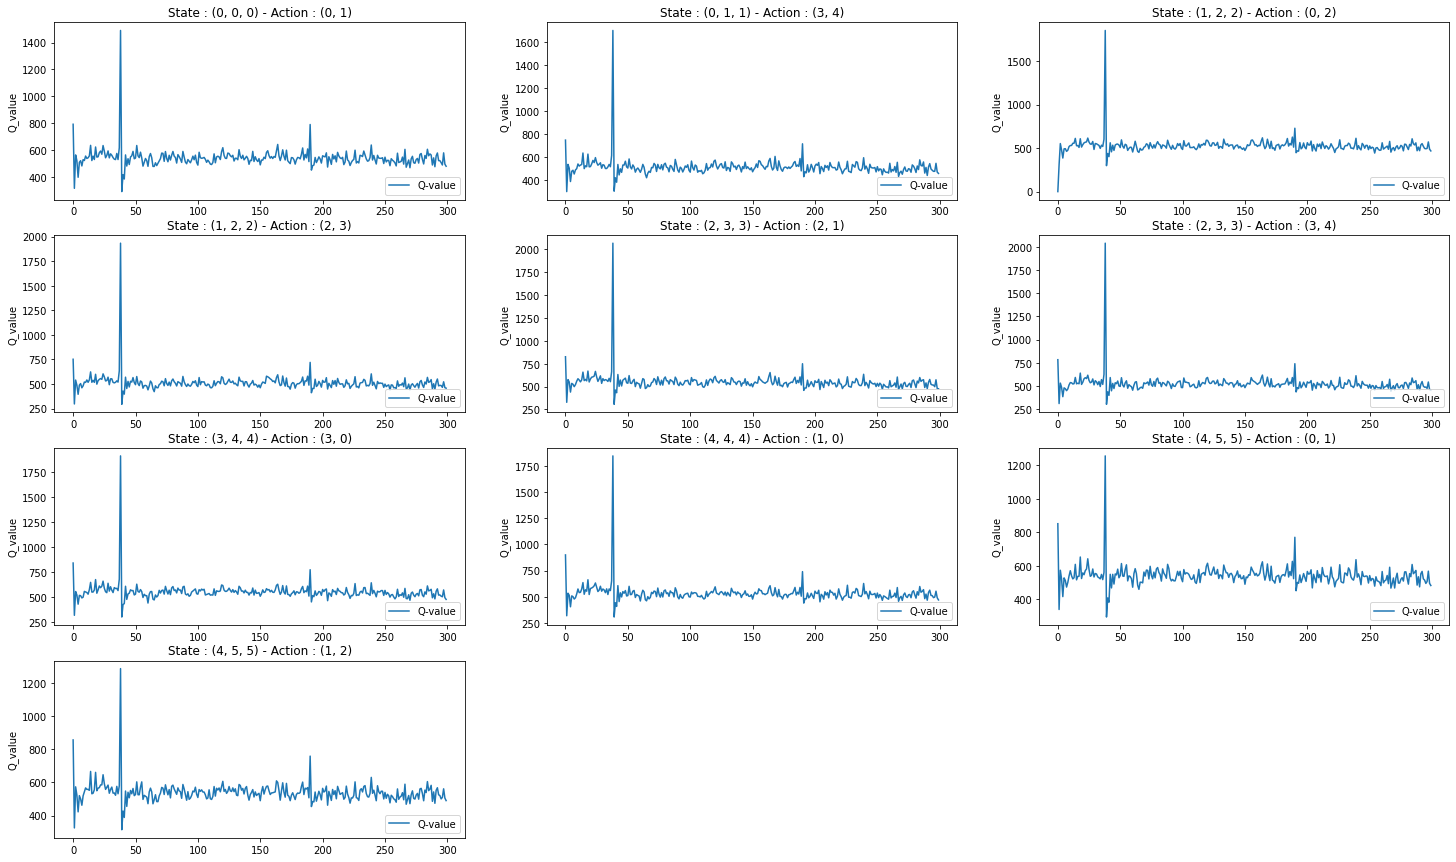

In [25]:
plt.figure(0, figsize=(25, 15))
i = 0
for state, action in tracked_states_plotting:
    plt.subplot(4,3, i + 1)
    plot_q_val_convergence(state, action)
    i +=1

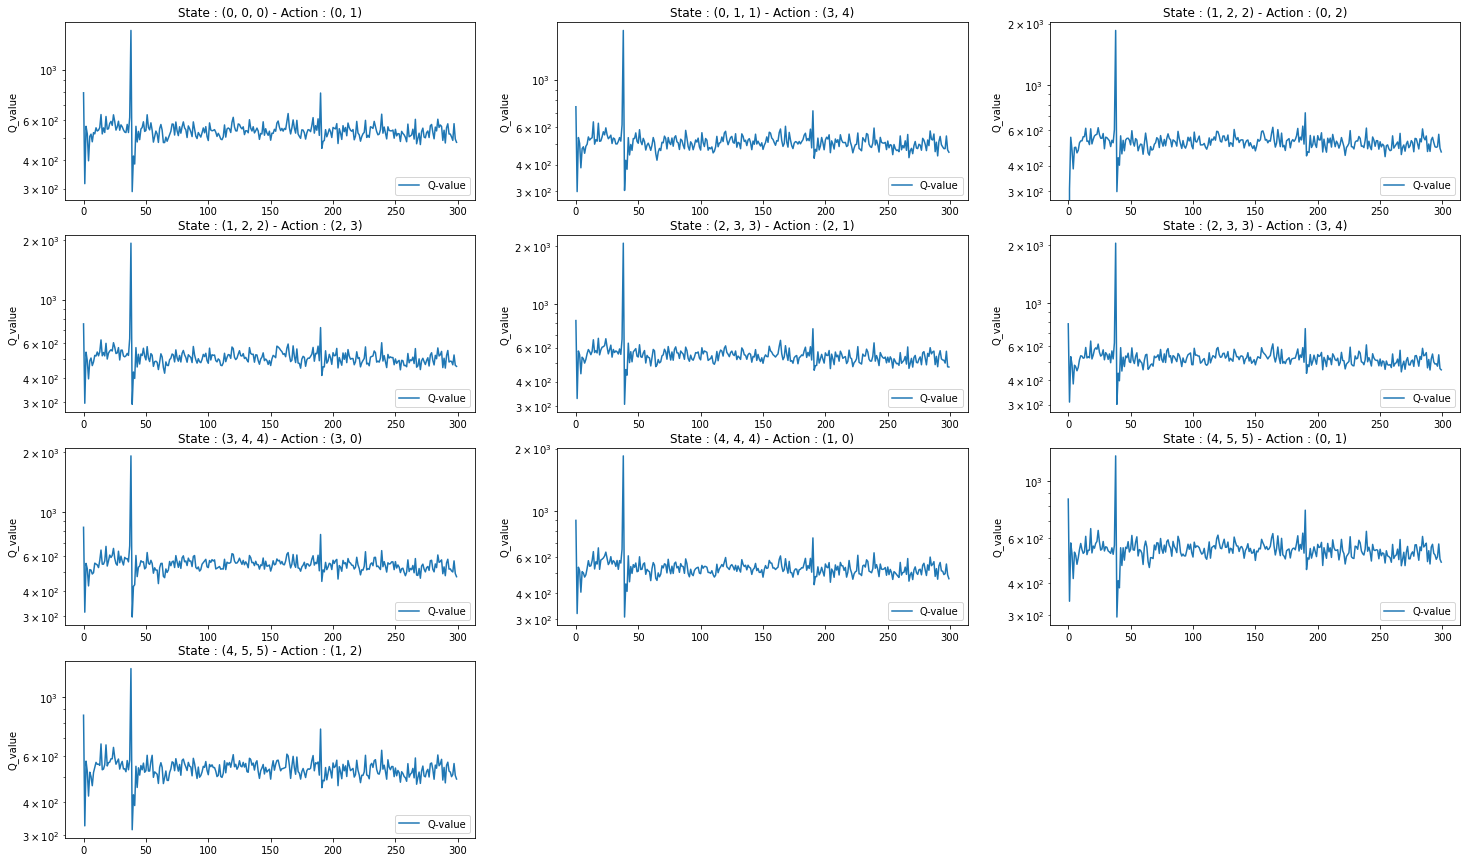

In [26]:
plt.figure(0, figsize=(25, 15))
i = 0
for state, action in tracked_states_plotting:
    plt.subplot(4,3, i + 1)
    plot_q_val_log_convergence(state, action)
    i +=1

### Plotting Average Monthly Rewards

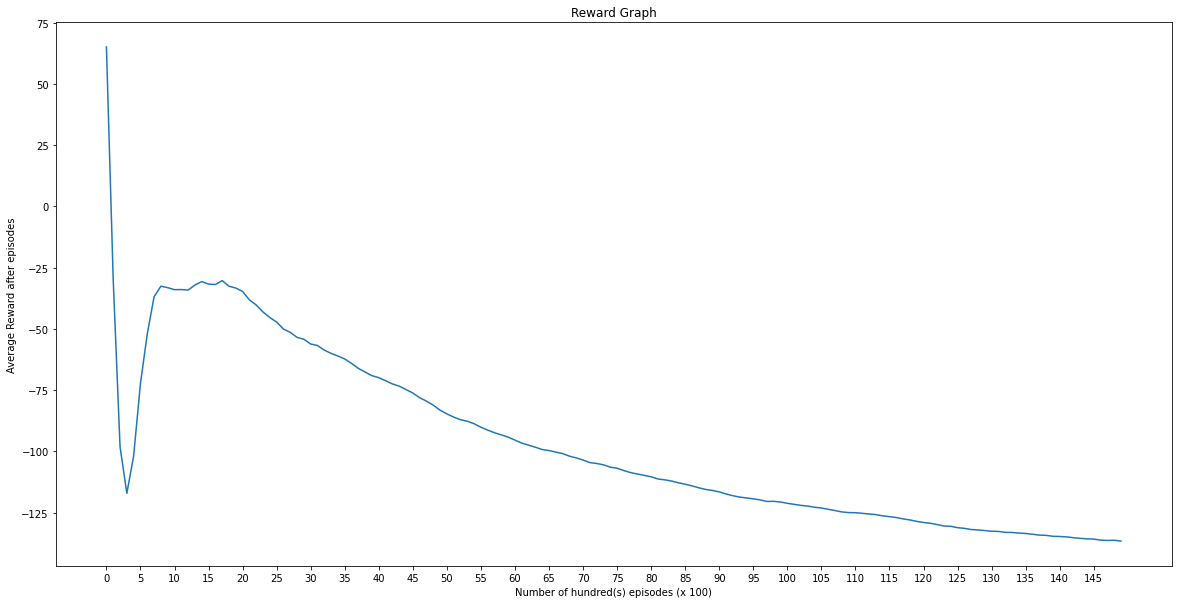

In [29]:
avg_monthly_rewards = [
    np.mean(rewards_per_episode[0:x + 99])
    for x in range(0, total_episodes, 100)
]

plt.figure(figsize=(20, 10))

plt.plot(range(0, len(avg_monthly_rewards)), avg_monthly_rewards)

plt.xlabel("Number of hundred(s) episodes (x 100)")
plt.ylabel("Average Reward after episodes")
plt.title("Reward Graph")
plt.xticks(range(0, 150, 5))

plt.show()